In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix


Paths and basic settings

In [3]:
DATASET_PATH = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR   = os.path.join(DATASET_PATH, "val")
TEST_DIR  = os.path.join(DATASET_PATH, "test")

In [4]:
IMG_SIZE = (224, 224)     # matched to dataset_preparation
BATCH_SIZE = 32           # keep moderate for VRAM and I/O
SEED = 42

In [5]:
class_names = ["notdrowsy", "drowsy"]   # 0 -> notdrowsy, 1 -> drowsy

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
print("Train dir:", TRAIN_DIR)
print("Val dir:", VAL_DIR)
print("Test dir:", TEST_DIR)

Train dir: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train
Val dir: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/val
Test dir: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/test


Dataset pipeline

In [8]:
def make_dataset(directory, shuffle, batch_size=BATCH_SIZE):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=class_names,
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED,
    )

    split_name = os.path.basename(directory)
    cache_path = f"/content/cache_{split_name}"

    ds = ds.cache(cache_path).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(TRAIN_DIR, shuffle=True)
val_ds   = make_dataset(VAL_DIR, shuffle=False)
test_ds  = make_dataset(TEST_DIR, shuffle=False)

Found 46564 files belonging to 2 classes.
Found 9978 files belonging to 2 classes.
Found 9979 files belonging to 2 classes.


Data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
    ],
    name="data_augmentation",
)

Build MobileNetV2 based model

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg",
)

# First, freeze base for warm-up training
base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="mobilenetv2_drowsiness")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
    ],
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_drowsiness"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch timing callback

In [11]:
class EpochTimeCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self.epoch_start
        print(f"\nEpoch {epoch+1} Time: {t:.2f} seconds")

epoch_timer = EpochTimeCallback()

Callbacks (early stopping, best model checkpoint)

In [12]:
checkpoint_path = os.path.join(DATASET_PATH, "mobilenetv2_best.keras")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6,
    ),
]


 Stage 1 - train only top layers

In [13]:
total_start = time.time()

In [14]:
EPOCHS_STAGE1 = 5

print("\n---------- STAGE 1: Training classifier head ----------\n")
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
)


---------- STAGE 1: Training classifier head ----------

Epoch 1/5
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5553 - auc: 0.5670 - loss: 0.7088 - precision: 0.5829 - recall: 0.6258
Epoch 1: val_loss improved from inf to 0.57351, saving model to /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_best.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 3106s 2s/step - accuracy: 0.5553 - auc: 0.5670 - loss: 0.7087 - precision: 0.5830 - recall: 0.6258 - val_accuracy: 0.7409 - val_auc: 0.8329 - val_loss: 0.5735 - val_precision: 0.7125 - val_recall: 0.8745 - learning_rate: 1.0000e-04
Epoch 2/5
1454/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6805 - auc: 0.7398 - loss: 0.5965 - precision: 0.6876 - recall: 0.7525
Epoch 2: val_loss improved from 0.57351 to 0.53084, saving model to /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_best.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.6805 - auc: 0.7398 - loss: 0

Stage 2 - fine tune part of MobileNetV2

In [15]:
# Unfreeze some layers of the base model for fine tuning

print("\n---------- STAGE 2: Fine-Tuning ----------\n")
fine_tune_at = 100  # you can adjust this number
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
    ],
)

EPOCHS_STAGE2 = 10

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
)


---------- STAGE 2: Fine-Tuning ----------

Epoch 1/10
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7740 - auc: 0.8532 - loss: 0.4714 - precision: 0.7975 - recall: 0.7740
Epoch 1: val_loss improved from 0.48238 to 0.33285, saving model to /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_best.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.7741 - auc: 0.8532 - loss: 0.4714 - precision: 0.7975 - recall: 0.7741 - val_accuracy: 0.8598 - val_auc: 0.9514 - val_loss: 0.3329 - val_precision: 0.8069 - val_recall: 0.9743 - learning_rate: 1.0000e-05
Epoch 2/10
1455/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8938 - auc: 0.9634 - loss: 0.2408 - precision: 0.8917 - recall: 0.9153
Epoch 2: val_loss improved from 0.33285 to 0.25245, saving model to /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_best.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8938 - auc: 0.9634 - loss: 0.2407

In [16]:
total_end = time.time()
total_training_time = total_end - total_start
print(f"\nTotal Training Time: {total_training_time/60:.2f} minutes\n")


Total Training Time: 64.32 minutes



Evaluate on test set

In [17]:
print("\n---------- TEST EVALUATION ----------\n")
test_results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, test_results)))


---------- TEST EVALUATION ----------

312/312 ━━━━━━━━━━━━━━━━━━━━ 891s 3s/step - accuracy: 0.9490 - auc: 0.5405 - loss: 0.1260 - precision: 0.4620 - recall: 0.5137
Test results: {'loss': 0.13402734696865082, 'compile_metrics': 0.9440825581550598}


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf

best_model_path = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_best.keras"
model = tf.keras.models.load_model(best_model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [3]:
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
class_names = ["notdrowsy", "drowsy"]

TEST_DIR = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/test"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    class_names=class_names,
)


Found 9979 files belonging to 2 classes.


In [4]:
import numpy as np

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)


In [5]:
y_pred_probs = model.predict(test_ds).ravel()


312/312 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step


In [6]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_true, y_pred_probs)
print("AUC (scikit-learn):", auc_score)


AUC (scikit-learn): 0.9890654938604435


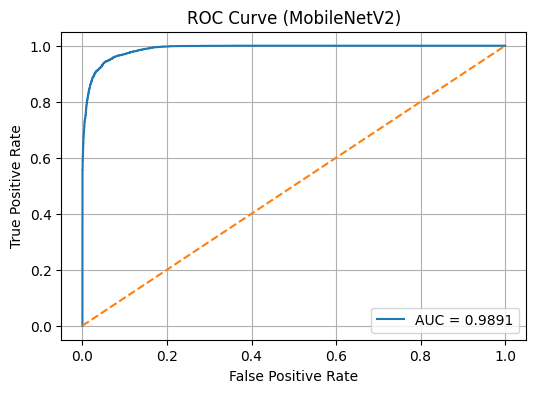

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MobileNetV2)")
plt.legend()
plt.grid(True)
plt.show()


Inference timing per image

In [9]:
import time

In [10]:
print("\n---------- INFERENCE TIMING ----------\n")

single_batch = next(iter(test_ds))
sample_img = single_batch[0][0]     # take first image
sample_img = tf.expand_dims(sample_img, axis=0)

# Warm-up (avoids measuring graph compile time)
_ = model.predict(sample_img)

start = time.time()
for _ in range(50):
    _ = model.predict(sample_img)
end = time.time()

avg_inf = (end - start) / 50
print(f"Average inference time per image: {avg_inf*1000:.2f} ms")


---------- INFERENCE TIMING ----------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━

Classification report on test set

In [19]:
print("\n---------- CLASSIFICATION REPORT ----------\n")

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs.ravel() >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion Matrix (TEST):")
print(confusion_matrix(y_true, y_pred))



---------- CLASSIFICATION REPORT ----------

312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step

Classification Report:
              precision    recall  f1-score   support

   notdrowsy       0.93      0.94      0.94      4574
      drowsy       0.95      0.94      0.95      5405

    accuracy                           0.94      9979
   macro avg       0.94      0.94      0.94      9979
weighted avg       0.94      0.94      0.94      9979

Confusion Matrix (TEST):
[[4319  255]
 [ 303 5102]]


 Save final model

In [20]:
final_model_path = os.path.join(DATASET_PATH, "mobilenetv2_nthu_ddd_final.keras")
model.save(final_model_path)
print("Saved final model to:", final_model_path)
print("Best checkpoint saved to:", checkpoint_path)

Saved final model to: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_nthu_ddd_final.keras
Best checkpoint saved to: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/mobilenetv2_best.keras


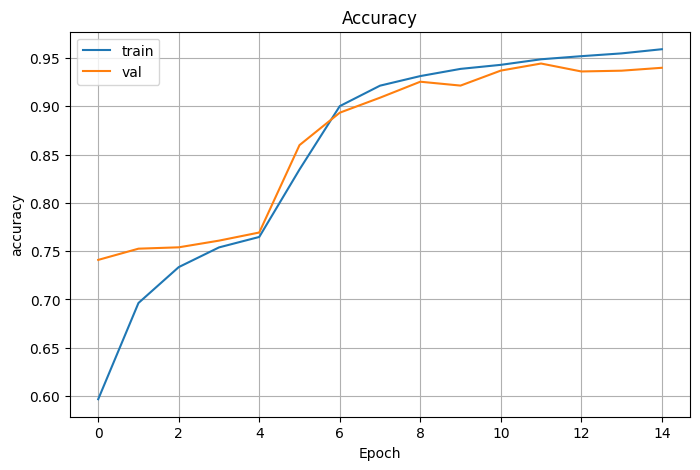

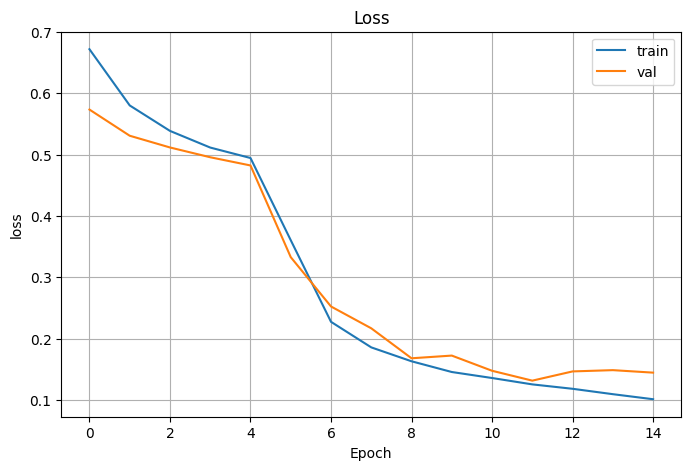

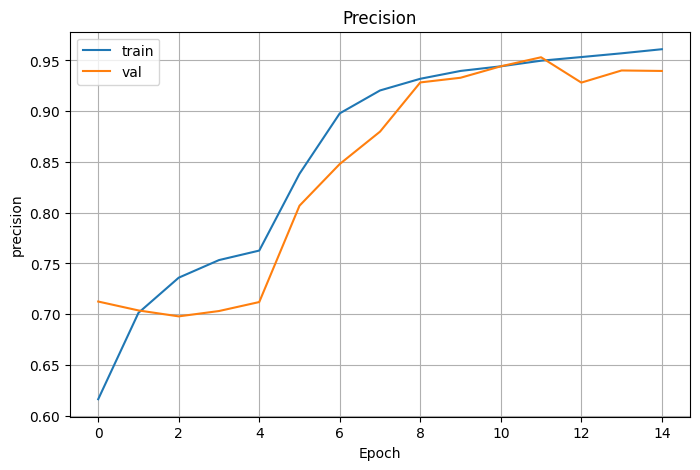

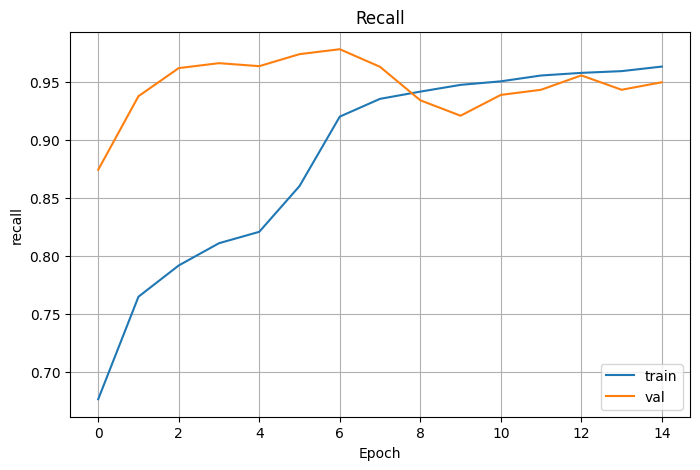

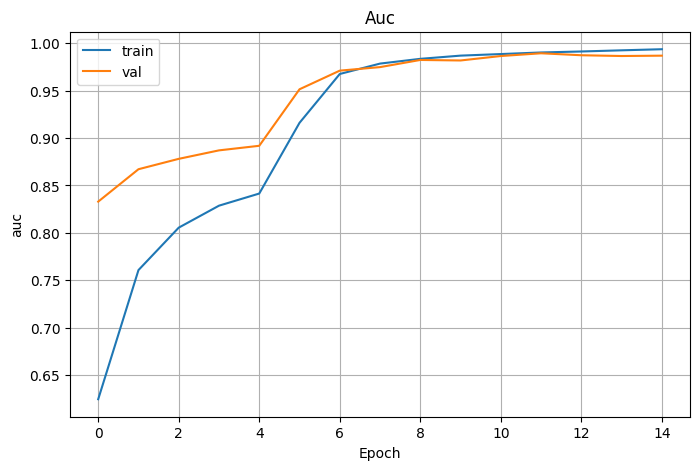

In [21]:
import matplotlib.pyplot as plt

# Combine history1 and history2
def combine_histories(h1, h2):
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]
    return history

full_history = combine_histories(history_stage1, history_stage2)

def plot_metric(metric_name):
    plt.figure(figsize=(8, 5))
    plt.plot(full_history[metric_name], label='train')
    plt.plot(full_history['val_' + metric_name], label='val')
    plt.title(metric_name.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

for metric in ["accuracy", "loss", "precision", "recall", "auc"]:
    plot_metric(metric)


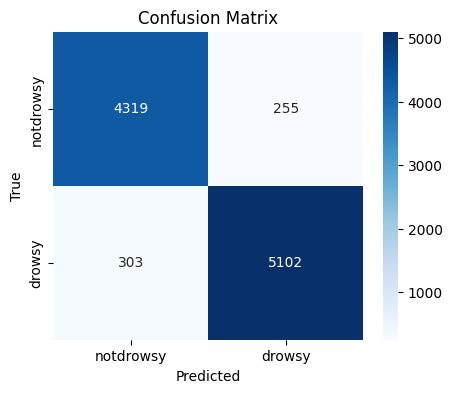

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [23]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.style.background_gradient(cmap="Blues")


,precision,recall,f1-score,support
notdrowsy,0.934444,0.944250,0.939321,4574.000000
drowsy,0.952399,0.943941,0.948151,5405.000000
accuracy,0.944083,0.944083,0.944083,0.944083
macro avg,0.943421,0.944095,0.943736,9979.000000
weighted avg,0.944169,0.944083,0.944104,9979.000000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


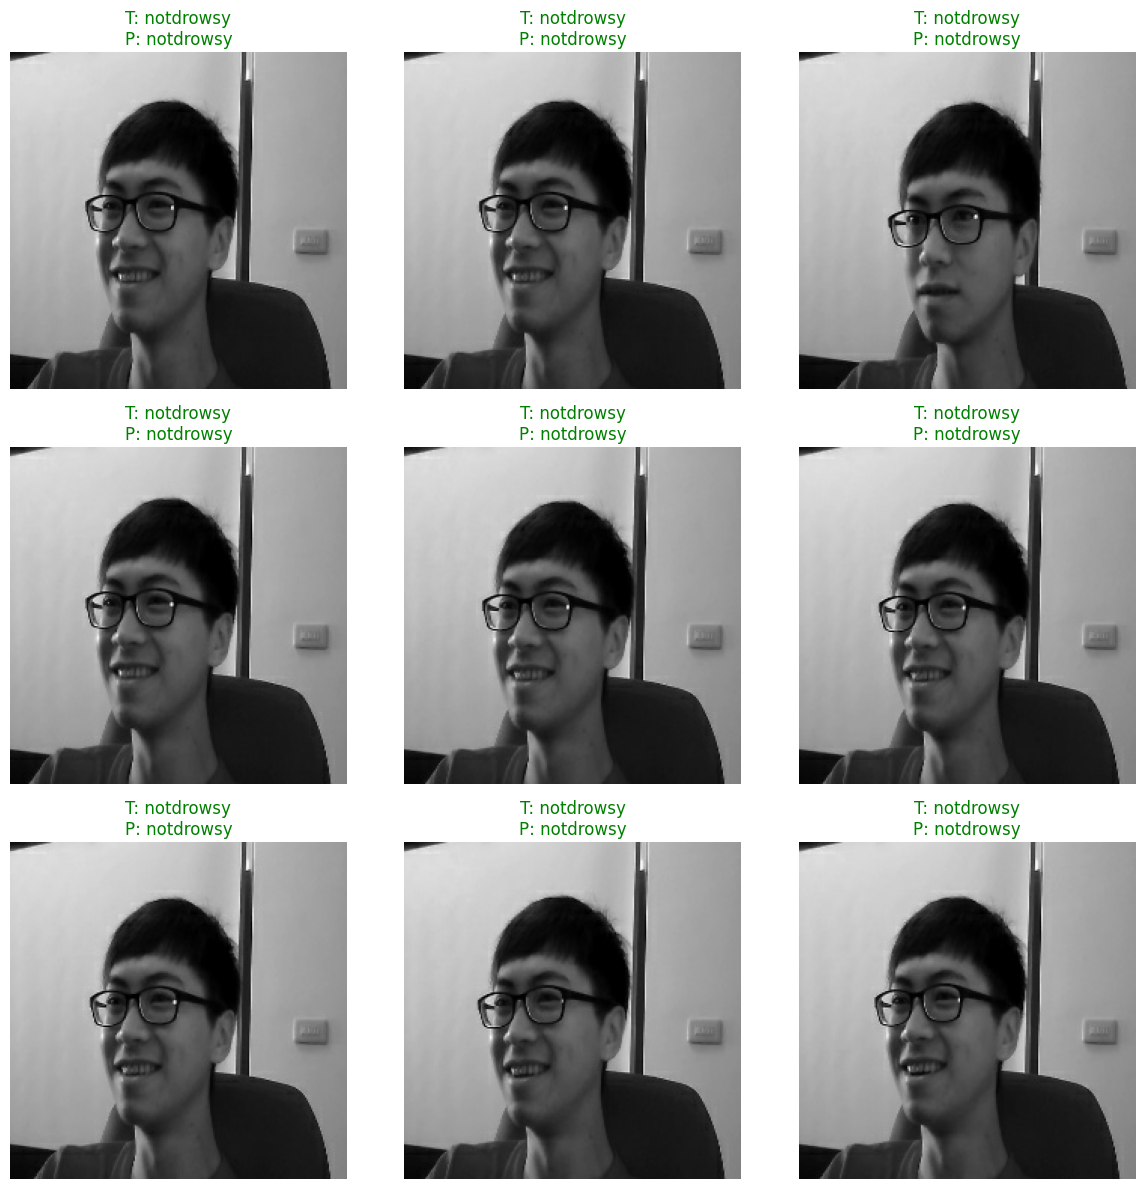

In [25]:
import matplotlib.pyplot as plt

test_batch = next(iter(test_ds))
images, labels = test_batch

preds = model.predict(images)
preds = (preds.ravel() >= 0.5).astype(int)

plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = class_names[labels[i].numpy()]
    pred_label = class_names[preds[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()
